In [1]:
import math
import os
import glob
import csv

import numpy as np
import numpy.ma as ma
from numpy import arange,array,ones
from numpy import exp, linspace, random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.mlab as mlab
from matplotlib import cm

from astropy.io import fits
from astropy.modeling import models, fitting
import astropy.io.ascii as a

from uncertainties import unumpy
from uncertainties import ufloat

import pylab as plb

from scipy.optimize import curve_fit
from scipy.optimize import leastsq as lmfitter
from scipy import signal
from scipy import asarray as ar,exp
from scipy.stats import chisquare
from scipy.stats import stats
from scipy.integrate import quad

import scipy.io
import scipy.integrate as integrate

from IPython.display import display, Math

from mpl_toolkits.mplot3d import Axes3D

from itertools import chain

import sherpa.ui as ui
import pandas as pd
from sklearn.linear_model import LinearRegression

%matplotlib inline


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
#Emission Lines (Vacuum)

OVI = 1033.82 
Ly_Alpha = 1215.24  
NV = 1240.81  
OI = 1305.53  
CII = 1335.31  
Si_IV = 1397.61  
Si_IV_O_IV = 1399.8  
CIV = 1549.48  
He_II = 1640.4
OIII = 1665.85 
Al_III = 1857.4 
CIII = 1908.734 
CII = 2326.0 
Ne_IV = 2439.5 
Mg_II = 2799.117 
Ne_V = 3346.79 #*
Ne_VI = 3426.85 
Fe_VII_1 = 3586 #*
Fe_VII_2 = 3760 #*
OII_1 = 3727.092 
OII_2 = 3729.875  
He_I = 3889.0 
SII = 4072.3 
H = 4102.89 
H = 4341.68  
OIII_1 = 4364.436  
H_Beta = 4862.68  
OIII_2 = 4932.603  
OIII_3 = 4960.295  
OIII_4 = 5008.240  
Fe_VII_3 = 6086 #*
OI_1 = 6302.046  
OI_2 = 6365.536  
Fe_X = 6374 #* Very hard to detect because it is so weak. 
NI = 6529.03  
NII = 6549.86 
H_Alpha = 6564.614  
NII = 6585.27  
SII = 6718.29  
SII = 6732.67  

#Absorption Lines

K = 3934.777  
H = 3969.588 
G = 4305.61  
Mg = 5176.7  
Na = 5895.6  
CaII_1 = 8500.36  
CaII_2 = 8544.44  
CaII_3 = 8664.52  

#Sky Lines

Sky_1 = 5578.5 
Sky_2 = 5894.6  
Sky_3 = 6301.7  
Sky_4 = 7246.0 

In [3]:
#Creating for loop to automatically import MaNGA galaxies

# for plate in range (7443, 7446, 1): 
#     for ifu in chain(range (1901,1903, 1), range(3701, 3705, 1), range (6101, 6105, 1), 
#                      range(9101, 9103, 1),range(12701, 12706, 1) ):
#         os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
#                   'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-7/VOR10-GAU-MILESHC/'
#                   +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
#                   +'-LOGCUBE-VOR10-GAU-MILESHC.fits.gz Test/')
#         os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
#                   'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-7/VOR10-GAU-MILESHC/'
#                   +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
#                   +'-MAPS-VOR10-GAU-MILESHC.fits.gz Test/')
#         os.system('gunzip Test/manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-GAU-MILESHC.fits.gz')
#         os.system('gunzip Test/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-GAU-MILESHC.fits.gz')


In [4]:
#Comparing rest vs. observed wavelength parameters

print ('H-Beta Rest Wavelength = ' + str(H_Beta))
print ('OIII Rest Wavelength = ' + str(OIII_4))
print ('H-Alpha Rest Wavelength = ' + str(H_Alpha))

print ('\n')

print ('-----------------------------------------------------------------------------')


#Opening drpall file to enable redshift for desired galaxies to be determined

drpall = fits.open('drpall-v2_4_3.fits')
tbdata = drpall[1].data

for fitsName in glob.glob('cg/vor10/*.fits'): #Reading in .fits Files
    hdulist = fits.open(fitsName) #Opening Fits File
    #hdulist.info()
    ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
    
    lambda_obs_0 = (tbdata['z'][ind][0] + 1)*H_Beta #Determining H-Beta Observed Wavelength
    lambda_obs_1 = (tbdata['z'][ind][0] + 1)*OIII_4 #Determining OIII Observed Wavelength
    lambda_obs_2 = (tbdata['z'][ind][0] + 1)*H_Alpha #Determining H-Alpha Observed Wavelength
    
    flux = hdulist[1].data.sum(axis=(1,2)) #Importing Flux Values 
    wavelength = hdulist[4].data #Importing Wavelength Values
    
    wavelength_0 = np.abs(wavelength - lambda_obs_0) #H-Beta
    wavelength_1 = np.abs(wavelength - lambda_obs_1) #OIII
    wavelength_2 = np.abs(wavelength - lambda_obs_2) #H-Alpha
    
    wavelength_min_0 = np.argmin(wavelength_0) #H-Beta
    wavelength_min_1 = np.argmin(wavelength_1) #OIII
    wavelength_min_2 = np.argmin(wavelength_2) #H-Alpha
    
    print ('\n')
    
    print ('IFU-Plate ID = ' + fitsName[15:-31] + ' / Manga-ID = '+ hdulist[0].header[59] + ' / redshift = ' 
           + str(tbdata['z'][ind][0]))
    
    print ('\n')
    
    print ('Expected Redshift-Corrected H-Beta Wavelength (Angstrom) = ' + str(lambda_obs_0)) 
    print ('Expected Redshift-Corrected OIII Wavelength (Angstrom) = ' + str(lambda_obs_1)) 
    print ('Expected Redshift-Corrected H-Alpha Wavelength (Angstrom) = ' + str(lambda_obs_2)) 
    
    print ('\n')
    
    print ('Closest Observed MaNGA H-Beta Wavelength (Angstrom) = ' + str(wavelength[wavelength_min_0]))
    print ('Closest Observed MaNGA OIII Wavelength (Angstrom) = ' + str(wavelength[wavelength_min_1]))
    print ('Closest Observed MaNGA H-Alpha Wavelength (Angstrom) = ' + str(wavelength[wavelength_min_2]))

    print ('\n')
    
    print ('H-Beta Observed MaNGA Flux (10^(-17) erg/s/cm2/angstrom/spaxel) = ' + str(flux[wavelength_min_0]))
    print ('OIII Observed MaNGA Flux (10^(-17) erg/s/cm2/angstrom/spaxel) = ' + str(flux[wavelength_min_1]))
    print ('H-Alpha Observed MaNGA Flux (10^(-17) erg/s/cm2/angstrom/spaxel) = ' + str(flux[wavelength_min_2]))
    
    print ('\n')
    
    print ('-----------------------------------------------------------------------------')
    hdulist.close()
    


H-Beta Rest Wavelength = 4862.68
OIII Rest Wavelength = 5008.24
H-Alpha Rest Wavelength = 6564.614


-----------------------------------------------------------------------------


IFU-Plate ID = 8134-9102 / Manga-ID = 1-339163 / redshift = 0.0312375


Expected Redshift-Corrected H-Beta Wavelength (Angstrom) = 5014.5779665
Expected Redshift-Corrected OIII Wavelength (Angstrom) = 5164.684897
Expected Redshift-Corrected H-Alpha Wavelength (Angstrom) = 6769.676129824999


Closest Observed MaNGA H-Beta Wavelength (Angstrom) = 5014.181
Closest Observed MaNGA OIII Wavelength (Angstrom) = 5164.1636
Closest Observed MaNGA H-Alpha Wavelength (Angstrom) = 6770.177


H-Beta Observed MaNGA Flux (10^(-17) erg/s/cm2/angstrom/spaxel) = 483.05307
OIII Observed MaNGA Flux (10^(-17) erg/s/cm2/angstrom/spaxel) = 520.171
H-Alpha Observed MaNGA Flux (10^(-17) erg/s/cm2/angstrom/spaxel) = 858.692


-----------------------------------------------------------------------------


IFU-Plate ID = 8138-6101 / Man

In [5]:
#Plotting summed flux maps

# for fitsName in glob.glob('cg/vor10/*.fits'):
#     hdulist = fits.open(fitsName)
#     flux = hdulist[1].data.sum(axis=(0))
#     wavelength = hdulist[4].data
#     print (fitsName[15:-31] + ' Dimensions = ' + str(hdulist[1].data.shape))
#     plt.imshow(np.fliplr(flux), cmap = 'magma')
#     plt.title(' IFU-Plate ID ' + fitsName[15:-31])
#     plt.xlabel('Declination')
#     plt.ylabel('Right Ascension')
#     plt.colorbar()
#     plt.show()
#     hdulist.close()
    
# #Plotting summed spectra 

# for fitsName in glob.glob('cg/vor10/*.fits'):
#     hdulist = fits.open(fitsName)
#     flux = hdulist[1].data.sum(axis=(1,2))
#     wavelength = hdulist[4].data
#     plt.figure(figsize = (15,10))
#     plt.plot(wavelength, flux)
#     plt.title(' IFU-Plate ID ' + fitsName[15:-31])
#     plt.xlabel('Wavelength (Angstrom)')
#     plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
#     plt.xlim(3550,10375)
#     plt.ylim(0,)
#     plt.show()
#     hdulist.close()

#print (repr(hdulist_test[0].header))


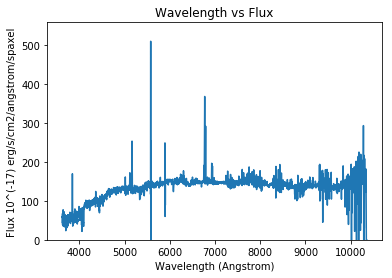

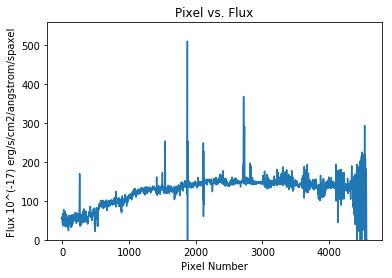

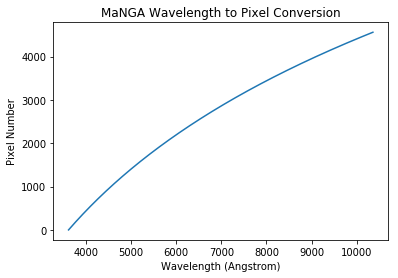

In [6]:
#Plotting Data

hdulist_8138_6101 = fits.open('cg/vor10/manga-8138-6101-LOGCUBE-VOR10-GAU-MILESHC.fits')
flux_pixel_8138_6101 = hdulist_8138_6101[1].data.sum(axis=(1,2))
wp_8138_6101 = hdulist_8138_6101[4].data

#print (flux_pixel_8138_6101.shape)

#Wavelength vs. Flux 
plt.plot(wp_8138_6101, flux_pixel_8138_6101)
plt.ylim(0,)
#plt.xlim(6500,6880)
plt.title('Wavelength vs Flux')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
plt.show()

#Pixel vs. Flux
plt.plot(flux_pixel_8138_6101)
plt.ylim(0,)
#plt.xlim(1500,1600)
plt.title('Pixel vs. Flux')
plt.xlabel('Pixel Number')
plt.ylabel('Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
plt.show()

#Pixel to Wavelength Conversion

pixel = np.arange(1,4564,1)

plt.plot(wp_8138_6101, pixel)
plt.title ('MaNGA Wavelength to Pixel Conversion')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Pixel Number')
plt.show()

formula: y = [[0.1902181]]x + [-841.03703214]


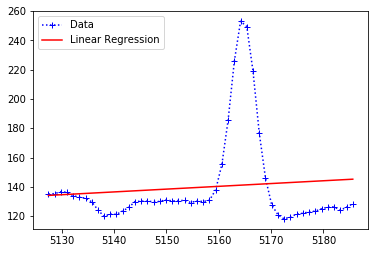

In [7]:
#Linear regression for continuum subtractionr

# Reshaping to one column (unknown rows)
wp_8138_6101_linear, flux_pixel_8138_6101_linear = wp_8138_6101[1510:1560].reshape(-1,1), flux_pixel_8138_6101[1510:1560].reshape(-1, 1)

# Fitting linear model to the data
lin_regression = LinearRegression()
lin_regression.fit(wp_8138_6101_linear,flux_pixel_8138_6101_linear)

# Get slope of fitted line
m = lin_regression.coef_

# Get y-Intercept of the Line
b = lin_regression.intercept_

# Get Predictions for original x values
predictions = lin_regression.predict(wp_8138_6101_linear)

# print (predictions [130:155])
# print (flux_pixel_8138_6101[1530:1555])

# following slope intercept form 
print ("formula: y = {0}x + {1}".format(m, b)) 

# Plotting the original spectrum and fit 
plt.plot(wp_8138_6101_linear, flux_pixel_8138_6101_linear,  'b+:', label = 'Data')
plt.plot(wp_8138_6101_linear, predictions, color='red', label = 'Linear Regression')
plt.legend(loc='best')
plt.show()

# Polyfit = np.polyfit(wp_8138_6101[1400:1600], flux_pixel_8138_6101[1400:1600], 1)
# Fit_1 = np.poly1d(Polyfit)
# plt.plot(wp_8138_6101[1400:1600], flux_pixel_8138_6101[1400:1600],  color='blue', label = 'Data')
# plt.plot(wp_8138_6101[1400:1600], Fit_1(wp_8138_6101[1400:1600]), color='red', label = 'Linear Regression')
# plt.legend(loc='best')
# plt.show()

# print (Fit_1(wp_8138_6101[1500]))

Amplitude = 130.74858373379243
Central Wavelength = 5164.586738659817
Sigma = 2.289584563210256
Offset = 125.39175814827472


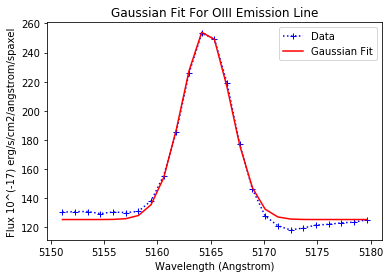

In [8]:
#Guassian Fit

#flux_correction = flux_pixel_8138_6101[1530:1555] - predictions[1530:1555]

def gaus(x,amp,x0,sigma, b):
    return amp*np.exp(-(x-x0)**2/(2*sigma**2))+ b

#inital guesses for (width, x position of peak, standard deviation, and continuum position along y-axis)
popt, pcov = curve_fit(gaus,wp_8138_6101[1530:1555],flux_pixel_8138_6101[1530:1555], p0=[120, 5165, 2.5, 127])
print ('Amplitude = ' + str(popt[0]))
print ('Central Wavelength = ' + str(popt[1]))
print ('Sigma = ' + str(popt[2]))
print ('Offset = ' + str(popt[3]))

#e^(-1/2) ~ 60% falloff
#Convert sigma to FWHM (>2 sigma). We want ~50%

# Plot the data with the best-fit model

plt.plot(wp_8138_6101[1530:1555], flux_pixel_8138_6101[1530:1555], 'b+:', label = 'Data')
plt.title('Gaussian Fit For OIII Emission Line')
plt.ylabel('Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
plt.xlabel('Wavelength (Angstrom)')
plt.plot(wp_8138_6101[1530:1555], gaus(wp_8138_6101[1530:1555], *popt), 'r-', label = 'Gaussian Fit')
plt.legend(loc = 'best')
plt.show()

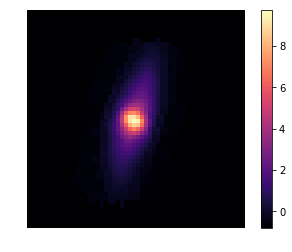

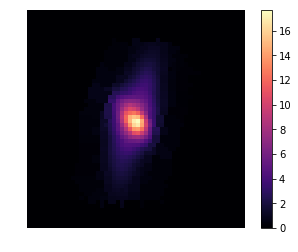

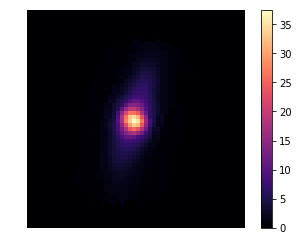

In [9]:
#Plotting Flux Maps

# #H-Beta
# print (wp_8138_6101[1411:1418])
# print(flux_pixel_8138_6101[1411:1418])

# #OIII
# print (wp_8138_6101[1538:1547])
# print(flux_pixel_8138_6101[1538:1547])

# #H-Alpha
# print (wp_8138_6101[2712:2723])
# print(flux_pixel_8138_6101[2712:2723])

#H-Beta
em_all_h_beta = np.empty((7, 54, 54))
for i, value in zip(range(7), range (1411, 1418)):
    em_all_h_beta[i, :, :] = hdulist_8138_6101[1].data[value,:,:] 
em_sum_h_beta = np.sum(em_all_h_beta, axis = 0)
em_total_h_beta = em_sum_h_beta - 0.8
#print(em_sum.shape)

#H-Beta Plot
plt.imshow(np.fliplr(em_total_h_beta), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8138-6101-H_Beta.png', dpi=600, format='png', bbox_inches='tight', transparent=True)
plt.show()

#OIII
em_all_oiii = np.empty((9, 54, 54))
for i, value in zip(range(9), range (1538, 1547)):
    em_all_oiii[i, :, :] = hdulist_8138_6101[1].data[value,:,:]
em_sum_oiii = np.sum(em_all_oiii, axis = 0)
em_total_oiii = em_sum_oiii 

#OIII Plot
plt.imshow(np.fliplr(em_total_oiii), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8138-6101_O_III.png', dpi=600, format='png', bbox_inches='tight', transparent=True)
plt.show()

#H-Alpha
em_all_h_alpha = np.empty((11, 54, 54))
for i, value in zip(range(11), range (2712, 2723)):
    em_all_h_alpha[i, :, :] = hdulist_8138_6101[1].data[value,:,:] 
em_sum_h_alpha = np.sum(em_all_h_alpha, axis = 0)
em_total_h_alpha = em_sum_h_alpha 

#H-Alpha Plot
plt.imshow(np.fliplr(em_total_h_alpha), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8138-6101_H_Alpha.png', dpi=600, format='png', bbox_inches='tight', transparent=True)
plt.show()


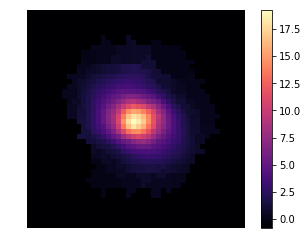

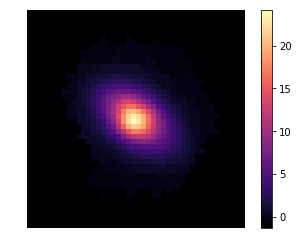

In [10]:
hdulist_8249_3704 = fits.open('cg/vor10/manga-8249-3704-LOGCUBE-VOR10-GAU-MILESHC.fits')
flux_pixel_8249_3704 = hdulist_8249_3704[1].data.sum(axis=(1,2))
wp_8249_3704 = hdulist_8249_3704[4].data

#Wavelength vs. Flux 
# plt.plot(wp_8249_3704, flux_pixel_8249_3704)
# plt.ylim(0,)
# plt.xlim(4980,5000)
# plt.xlabel('Wavelength (Angstrom)')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

# #Pixel vs. Flux
# plt.plot(flux_pixel_8249_3704)
# plt.ylim(0,)
# plt.xlim(1450,1550)
# plt.xlabel('Pixel Number')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

#H-Beta
# print (wp_8249_3704[1420:1430])
# print(flux_pixel_8249_3704[1420:1430])

#OIII
# print (wp_8249_3704[1517:1529])
# print(flux_pixel_8249_3704[1517:1529])

#H-Alpha
# print (wp[2692:2705])
# print(flux_pixel_8249_3704[2692:2705])

#H-Beta
# em_all_h_beta = np.empty((10, 54, 54))
# for i, value in zip(range(10), range (1420, 1430)):
#     em_all_h_beta[i, :, :] = hdulist_8249_3704[1].data[value,:,:]
# em_sum_h_beta = np.sum(em_all_h_beta, axis = 0)
# em_total_h_beta = em_sum_h_beta - 3
# print(em_sum.shape)

#H-Beta Plot
# plt.imshow(np.fliplr(em_total_h_beta), cmap = 'magma')
# plt.colorbar
# plt.xlabel('Declination')
# plt.ylabel('Right Ascension')
# plt.title("8249-3704-H-Beta")
# plt.axis('off')
# plt.savefig('8249-3704_H_Beta.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
# plt.show()

# #OIII
em_all_oiii = np.empty((12, 44, 44))
for i, value in zip(range(12), range (1517, 1529)):
    em_all_oiii[i, :, :] = hdulist_8249_3704[1].data[value,:,:]
em_sum_oiii = np.sum(em_all_oiii, axis = 0)
em_total_oiii = em_sum_oiii - 0.8
#print(em_sum.shape)

# #OIII Plot
plt.imshow(np.fliplr(em_total_oiii), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8249-3704_O_III.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

# #H-Alpha
em_all_h_alpha = np.empty((13, 44, 44))
for i, value in zip(range(13), range (2692, 2705)):
    em_all_h_alpha[i, :, :] = hdulist_8249_3704[1].data[value,:,:]
em_sum_h_alpha = np.sum(em_all_h_alpha, axis = 0)
em_total_h_alpha = em_sum_h_alpha - 1.3
# #print(em_sum.shape)

# #H-Alpha Plot
plt.imshow(np.fliplr(em_total_h_alpha), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8249-3704_H_Alpha.png', dpi=600, format='png', bbox_inches='tight', transparent=True)
plt.show()

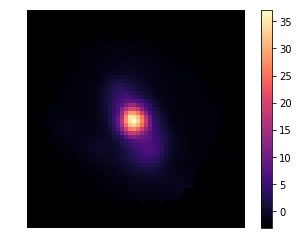

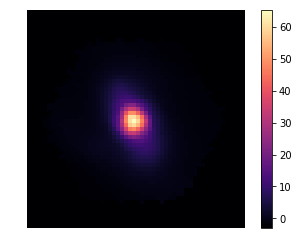

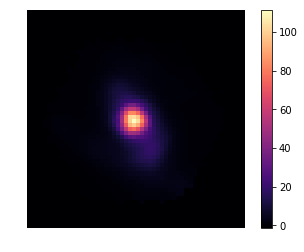

In [11]:
hdulist_8439_6102 = fits.open('cg/vor10/manga-8439-6102-LOGCUBE-VOR10-GAU-MILESHC.fits')
flux_pixel_8439_6102 = hdulist_8439_6102[1].data.sum(axis=(1,2))
wp_8439_6102 = hdulist_8439_6102[4].data

#Wavelength vs. Flux 
# plt.plot(wp_8439_6102, flux_pixel_8439_6102)
# plt.ylim(0,)
# plt.xlim(6600,6900)
# plt.xlabel('Wavelength (Angstrom)')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

# #Pixel vs. Flux
# plt.plot(flux_pixel_8439_6102)
# plt.ylim(0,)
# plt.xlim(2700,2750)
# plt.xlabel('Pixel Number')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

#H-Beta
# print (wp_8439_6102[1420:1430])
# print(flux_pixel_8439_6102[1420:1430])

#OIII
# print (wp_8439_6102[1545:1560])
# print(flux_pixel_8439_6102[1545:1560])

#H-Alpha
# print (wp_8439_6102[2723:2734])
# print(flux_pixel_8439_6102[2723:2734])

#H-Beta
em_all_h_beta = np.empty((10, 54, 54))
for i, value in zip(range(10), range (1420, 1430)):
    em_all_h_beta[i, :, :] = hdulist_8439_6102[1].data[value,:,:]
em_sum_h_beta = np.sum(em_all_h_beta, axis = 0)
em_total_h_beta = em_sum_h_beta - 3
# print(em_sum.shape)

#H-Beta Plot
plt.imshow(np.fliplr(em_total_h_beta), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8439-6102_H_Beta.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

# #OIII
em_all_oiii = np.empty((15, 54, 54))
for i, value in zip(range(15), range (1545, 1560)):
    em_all_oiii[i, :, :] = hdulist_8439_6102[1].data[value,:,:]
em_sum_oiii = np.sum(em_all_oiii, axis = 0)
em_total_oiii = em_sum_oiii - 3
#print(em_sum.shape)

# #OIII Plot
plt.imshow(np.fliplr(em_total_oiii), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8439-6102_O_III.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

# #H-Alpha
em_all_h_alpha = np.empty((11, 54, 54))
for i, value in zip(range(11), range (2723, 2734)):
    em_all_h_alpha[i, :, :] = hdulist_8439_6102[1].data[value,:,:]
em_sum_h_alpha = np.sum(em_all_h_alpha, axis = 0)
em_total_h_alpha = em_sum_h_alpha - 1.3
# #print(em_sum.shape)

# #H-Alpha Plot
plt.imshow(np.fliplr(em_total_h_alpha), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8439-6102_H_Alpha.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

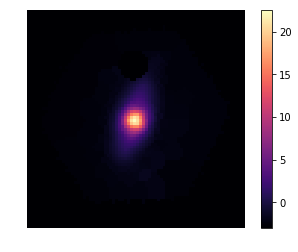

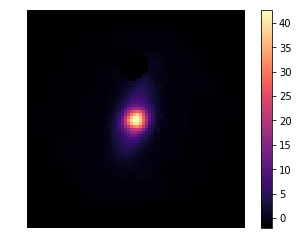

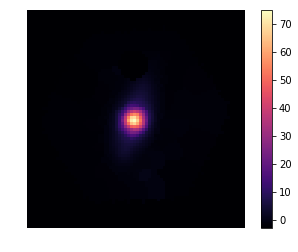

In [12]:
hdulist_8547_12701 = fits.open('cg/vor10/manga-8547-12701-LOGCUBE-VOR10-GAU-MILESHC.fits')
flux_pixel_8547_12701 = hdulist_8547_12701[1].data.sum(axis=(1,2))
wp_8547_12701 = hdulist_8547_12701[4].data

#Wavelength vs. Flux 
# plt.plot(wp_8547_12701, flux_pixel_8547_12701)
# plt.ylim(0,)
# plt.xlim(6700,7000)
# plt.xlabel('Wavelength (Angstrom)')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

# #Pixel vs. Flux
# plt.plot(flux_pixel_8547_12701)
# plt.ylim(0,)
# plt.xlim(2650,2800)
# plt.xlabel('Pixel Number')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

#H-Beta
# print (wp_8547_12701[1420:1430])
# print(flux_pixel_8547_12701[1420:1430])

#OIII
# print (wp_8547_12701[1591:1605])
# print(flux_pixel_8547_12701[1591:1605])

#H-Alpha
# print (wp_8547_12701[2767:2780])
# print(flux_pixel_8547_12701[2767:2780])

#H-Beta
em_all_h_beta = np.empty((10, 74, 74))
for i, value in zip(range(10), range (1465, 1475)):
    em_all_h_beta[i, :, :] = hdulist_8547_12701[1].data[value,:,:]
em_sum_h_beta = np.sum(em_all_h_beta, axis = 0)
em_total_h_beta = em_sum_h_beta - 3
# print(em_sum.shape)

# H-Beta Plot
plt.imshow(np.fliplr(em_total_h_beta), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8547-12701_H_Beta.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

# #OIII
em_all_oiii = np.empty((14, 74, 74))
for i, value in zip(range(14), range (1591, 1605)):
    em_all_oiii[i, :, :] = hdulist_8547_12701[1].data[value,:,:]
em_sum_oiii = np.sum(em_all_oiii, axis = 0)
em_total_oiii = em_sum_oiii - 2
#print(em_sum.shape)

# #OIII Plot
plt.imshow(np.fliplr(em_total_oiii), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8547-12701_O_III.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

# #H-Alpha
em_all_h_alpha = np.empty((13, 74, 74))
for i, value in zip(range(13), range (2767, 2780)):
    em_all_h_alpha[i, :, :] = hdulist_8547_12701[1].data[value,:,:]
em_sum_h_alpha = np.sum(em_all_h_alpha, axis = 0)
em_total_h_alpha = em_sum_h_alpha - 2.8
# #print(em_sum.shape)

# #H-Alpha Plot
plt.imshow(np.fliplr(em_total_h_alpha), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8547-12701_H_Alpha.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

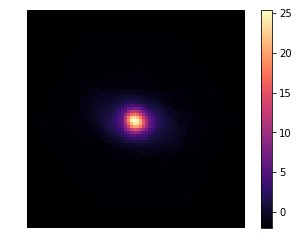

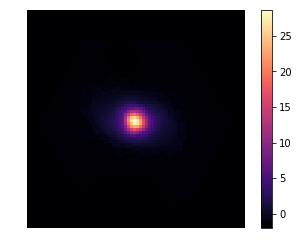

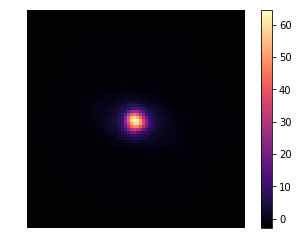

In [13]:
hdulist_8549_12701 = fits.open('cg/vor10/manga-8549-12701-LOGCUBE-VOR10-GAU-MILESHC.fits')
flux_pixel_8549_12701 = hdulist_8547_12701[1].data.sum(axis=(1,2))
wp_8549_12701 = hdulist_8549_12701[4].data

#Wavelength vs. Flux 
# plt.plot(wp_8549_12701, flux_pixel_8549_12701)
# plt.ylim(0,)
# plt.xlim(6500,7000)
# plt.xlabel('Wavelength (Angstrom)')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

#Pixel vs. Flux
# plt.plot(flux_pixel_8549_12701)
# plt.ylim(0,)
# plt.xlim(2700,2795)
# plt.xlabel('Pixel Number')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

#H-Beta
# print (wp_8549_12701[1465:1476])
# print(flux_pixel_8549_12701[1465:1476])

# #OIII
# print (wp_8549_12701[1593:1604])
# print(flux_pixel_8549_12701[1593:1604])

# #H-Alpha
# print (wp_8549_12701[2768:2780])
# print(flux_pixel_8549_12701[2768:2780])

#H-Beta
em_all_h_beta = np.empty((11, 74, 74))
for i, value in zip(range(11), range (1465, 1476)):
    em_all_h_beta[i, :, :] = hdulist_8549_12701[1].data[value,:,:]
em_sum_h_beta = np.sum(em_all_h_beta, axis = 0)
em_total_h_beta = em_sum_h_beta - 2
# print(em_sum.shape)

# H-Beta Plot
plt.imshow(np.fliplr(em_total_h_beta), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8549-12701_H_Beta.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

# #OIII
em_all_oiii = np.empty((11, 74, 74))
for i, value in zip(range(11), range (1593, 1604)):
    em_all_oiii[i, :, :] = hdulist_8549_12701[1].data[value,:,:]
em_sum_oiii = np.sum(em_all_oiii, axis = 0)
em_total_oiii = em_sum_oiii - 2
#print(em_sum.shape)

# #OIII Plot
plt.imshow(np.fliplr(em_total_oiii), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8549-12701_O_III.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

# #H-Alpha
em_all_h_alpha = np.empty((12, 74, 74))
for i, value in zip(range(12), range (2768, 2780)):
    em_all_h_alpha[i, :, :] = hdulist_8549_12701[1].data[value,:,:]
em_sum_h_alpha = np.sum(em_all_h_alpha, axis = 0)
em_total_h_alpha = em_sum_h_alpha - 2.8
# #print(em_sum.shape)

# #H-Alpha Plot
plt.imshow(np.fliplr(em_total_h_alpha), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8549-12701_H_Alpha.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

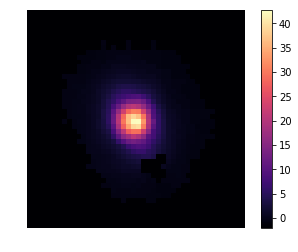

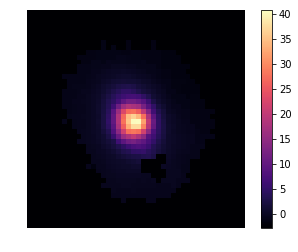

In [14]:
hdulist_8550_3704 = fits.open('cg/vor10/manga-8550-3704-LOGCUBE-VOR10-GAU-MILESHC.fits')
flux_pixel_8550_3704 = hdulist_8550_3704[1].data.sum(axis=(1,2))
wp_8550_3704 = hdulist_8550_3704[4].data

# #Wavelength vs. Flux 
# plt.plot(wp_8550_3704, flux_pixel_8550_3704)
# plt.ylim(0,)
# plt.xlim(6600,6800)
# plt.xlabel('Wavelength (Angstrom)')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

# #Pixel vs. Flux
# plt.plot(flux_pixel_8550_3704)
# plt.ylim(0,)
# plt.xlim(2650,2755)
# plt.xlabel('Pixel Number')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

#H-Beta
# print (wp_8550_3704[1465:1476])
# print(flux_pixel_8549_12701[1465:1476])

# #OIII
# print (wp_8550_3704[1530:1542])
# print(flux_pixel_8550_3704[1530:1542])

# #H-Alpha
# print (wp_8550_3704[2705:2717])
# print(flux_pixel_8550_3704[2706:2717])

# #H-Beta
# em_all_h_beta = np.empty((11, 44, 44))
# for i, value in zip(range(11), range (1465, 1476)):
#     em_all_h_beta[i, :, :] = hdulist_8550_3704[1].data[value,:,:]
# em_sum_h_beta = np.sum(em_all_h_beta, axis = 0)
# em_total_h_beta = em_sum_h_beta - 2
# # print(em_sum.shape)

# #H-Beta Plot
# plt.imshow(np.fliplr(em_total_h_beta), cmap = 'magma')
# plt.colorbar
# plt.axis('off')
# plt.savefig('8550-3704_H_Beta.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
# plt.show()

#OIII
em_all_oiii = np.empty((12, 44, 44))
for i, value in zip(range(12), range (1530, 1542)):
    em_all_oiii[i, :, :] = hdulist_8550_3704[1].data[value,:,:]
em_sum_oiii = np.sum(em_all_oiii, axis = 0)
em_total_oiii = em_sum_oiii - 2

#OIII Plot
plt.imshow(np.fliplr(em_total_oiii), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8550-3704_O_III.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

#H-Alpha
em_all_h_alpha = np.empty((12, 44, 44))
for i, value in zip(range(12), range (2705, 2717)):
    em_all_h_alpha[i, :, :] = hdulist_8550_3704[1].data[value,:,:]
em_sum_h_alpha = np.sum(em_all_h_alpha, axis = 0)
em_total_h_alpha = em_sum_h_alpha - 2.8

#H-Alpha Plot
plt.imshow(np.fliplr(em_total_h_alpha), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('8550-3704_H_Alpha.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

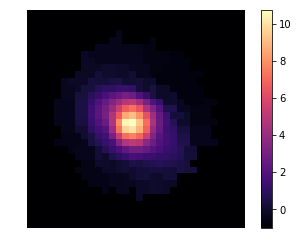

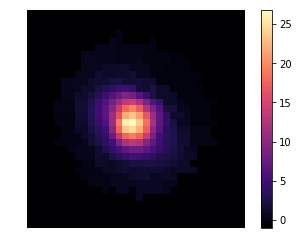

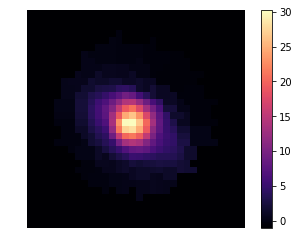

In [15]:
hdulist_9049_1901 = fits.open('cg/vor10/manga-9049-1901-LOGCUBE-VOR10-GAU-MILESHC.fits')
flux_pixel_9049_1901 = hdulist_9049_1901[1].data.sum(axis=(1,2))
wp_9049_1901 = hdulist_9049_1901[4].data

#Wavelength vs. Flux 
# plt.plot(wp_9049_1901, flux_pixel_9049_1901)
# plt.ylim(0,)
# plt.xlim(7350,7500)
# plt.xlabel('Wavelength (Angstrom)')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

# #Pixel vs. Flux
# plt.plot(flux_pixel_9049_1901)
# plt.ylim(0,)
# plt.xlim(1900,2000)
# plt.xlabel('Pixel Number')
# plt.ylabel('10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

#Defining the Gaussian 
# hist = np.histogram(Truncated_Signal_2.flatten().filled(), 
#                     bins=50, range =(-7,10))
# x_values = hist[1][:-1]
# y_values = hist[0]

# def gaus(x,a,x0,sigma):
#     return a*np.exp(-(x-x0)**2/(2*sigma**2))

# popt, pcov = curve_fit(gaus,x_values,y_values, p0=[1e5, 0, 5])

#H-Beta
# print (wp_9049_1901[1812:1820])
# print(flux_pixel_9049_1901[1812:1820])

# #OIII
# print (wp_9049_1901[1936:1950])
# print(flux_pixel_9049_1901[1936:1950])

# #H-Alpha
# print (wp_9049_1901[3110:3130])
# print(flux_pixel_9049_1901[3115:3125])

#H-Beta
em_all_h_beta = np.empty((8, 32, 32))
for i, value in zip(range(8), range (1812, 1820)):
    em_all_h_beta[i, :, :] = hdulist_9049_1901[1].data[value,:,:]
em_sum_h_beta = np.sum(em_all_h_beta, axis = 0)
em_total_h_beta = em_sum_h_beta - 1
# print(em_sum.shape)

#H-Beta Plot
plt.imshow(np.fliplr(em_total_h_beta), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('9049-1901_H_Beta.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

#OIII
em_all_oiii = np.empty((14, 32, 32))
for i, value in zip(range(14), range (1936, 1950)):
    em_all_oiii[i, :, :] = hdulist_9049_1901[1].data[value,:,:]
em_sum_oiii = np.sum(em_all_oiii, axis = 0)
em_total_oiii = em_sum_oiii - 1

#OIII Plot
plt.imshow(np.fliplr(em_total_oiii), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('9049-1901_O_III.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

#H-Alpha
em_all_h_alpha = np.empty((10, 32, 32))
for i, value in zip(range(10), range (3115, 3125)):
    em_all_h_alpha[i, :, :] = hdulist_9049_1901[1].data[value,:,:]
em_sum_h_alpha = np.sum(em_all_h_alpha, axis = 0)
em_total_h_alpha = em_sum_h_alpha - 1

#H-Alpha Plot
plt.imshow(np.fliplr(em_total_h_alpha), cmap = 'magma')
plt.colorbar()
plt.axis('off')
plt.savefig('9049-1901_H_Alpha.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
plt.show()

In [16]:
# for pixel in range (40, 45, 1): 
#     for pixel_2 in range (40, 45, 1):
#         hdulist_test = fits.open('manga-8138-6101-LOGCUBE-VOR10-GAU-MILESHC.fits')
#         flux_pixel = hdulist_test[1].data[:,pixel,pixel_2]
#         wavelength = hdulist_test[4].data
#         print (flux_pixel)
        #print (repr(hdulist_test[0].header))